In [1]:
import numpy as np
import pandas as pd
import os
import subprocess
import time
import matplotlib.pyplot as plt
import itertools
from copy import deepcopy

from rdkit import Chem
from rdkit.Chem import AllChem
import ase
from ase.io import read, write
from ase.units import Hartree
from ase.visualize import view

from ase.io.trajectory import Trajectory
import glob
import pickle

In [275]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

In [2]:
from osc_discovery.photocatalysis.adsorption.tools import prepare_substrate
from osc_discovery.photocatalysis.adsorption.optimal_configurations import find_optimal_adsorbate_configurations_sequential, relax_all_adsorbate_configurations, check_site_identity_volatilization
from osc_discovery.photocatalysis.thermodynamics.tools import single_run, multi_run

In [3]:
### For automatically reloading import modules... allows you to run changes to code in jupyter without having to reload
%load_ext autoreload
%autoreload 2

In [4]:
# Read Dataframe containing entire chemical space
path = os.getcwd() + '/data/'
file = 'df_chemical_space_chons_4rings.json'
p = pd.read_json(path+file, orient='split')

In [5]:
os.chdir('/home/scakolli/Thesis/osc_discovery/run')

----

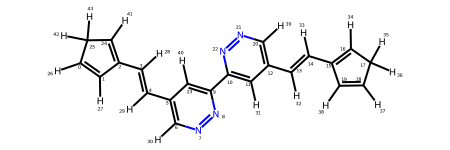

In [276]:
# Pick a random molecule in the space and get its smile string
rand_i = np.random.randint(315451)
smi = p.iloc[rand_i]['molecule_smiles']
# smi = 'C(#Cc1ccc[nH]1)c1cc(C#Cc2ccc[nH]2)cc(C2=NC=NC2)c1'
smi = 'C1=CC(C=Cc2cnnc(-c3cc(C=CC4=CCC=C4)cnn3)c2)=CC1'

# Draw chem
rdkit_smi = Chem.AddHs(Chem.MolFromSmiles(smi))
rdkit_smi

In [ ]:
p.iloc[rand_i]

## Run

In [ ]:
def clean_configs_with_nans(configs):
    # Take a list of configs and resort them according to active
    d = dict.fromkeys([i for i in range(sub.info['nonH_count'])], np.nan)
    cs = deepcopy(configs)

    for config in cs:
        actv = config.info['active_site']
        d[actv] = config

    return list(d.values())

In [7]:
calc_params = {'gfn':2, 'acc':0.2, 'etemp':298.15, 'strict':''}
sub, sub_confs = prepare_substrate(smi, calc_params, multi_process_conf=2, multi_process_sp=4)

Number of rotatable bonds: 5, C1=CC(C=Cc2cnnc(-c3cc(C=CC4=CCC=C4)cnn3)c2)=CC1
1) Embedding conformers (50). Using 2 processes
Took: 1.7221002578735352 s
2) Minimizing 50 conformers (mmff94)
Took: 2.1217455863952637 s
3) Pruning conformers (RMSD threshold: 0.35 Ang)
Took: 1.0798225402832031 s
Number of conformers found: 28


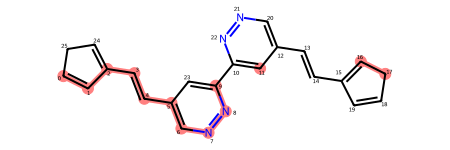

In [277]:
mol = Chem.MolFromSmiles(smi)
mol.__sssAtoms = [*sub.info['equivalent_atoms']]
mol

Grouping equivalent atoms such that they are closest to all the other equivalent atoms...

In [178]:
test = deepcopy(sub.info['equivalent_atoms_grouped'])
ts = []
for j, t in enumerate(test):
    dists = sub.get_distances(test[0][0], indices=t)
    ts.append(t[dists.argmin()])

print(ts, 'close grouping')
print([t[0] for t in test])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 23, 24, 25] close grouping
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 16, 17]


Minimizing multiple conformations... FFs do a good job of identifying lowest energy conf, but when it comes to generate confs of adsorbate configurations, it does quite poorly....

In [ ]:
confs_sp = multi_run(sub_confs, runtype='sp', keep_folders=False, calc_kwargs={}, multi_process=4)
indx = np.argmin([c.info['energy'] for c in confs_sp])
confs_opt_sp = single_run(sub_confs[indx], runtype='opt vtight', keep_folder=False, job_number=0)

In [ ]:
np.argsort([c.info['energy'] for c in confs_sp])

In [ ]:
sub.info['energy'], confs_opt_sp.info['energy']

In [ ]:
confs_opt = multi_run(sub_confs, runtype='opt vtight', keep_folders=False, calc_kwargs={}, multi_process=4)

In [ ]:
np.argsort([c.info['energy'] for c in confs_opt])

In [ ]:
confs_opt[0].info['energy']

-----

In [8]:
rc = relax_all_adsorbate_configurations(sub, calc_params, optlevel='vtight', keep_folders=True, multi_process=6)

2023-06-15 10:55:49,054 | INFO: OH active site scan
2023-06-15 10:55:49,132 | INFO: Jobs to do: 28
2023-06-15 10:56:45,683 | INFO: Finished jobs. Took 56.55045400000017s
2023-06-15 10:56:46,106 | INFO: O active site scan
2023-06-15 10:56:46,181 | INFO: Jobs to do: 28
2023-06-15 10:57:29,624 | INFO: Finished jobs. Took 43.4424584999997s
2023-06-15 10:57:30,035 | INFO: OOH active site scan
2023-06-15 10:57:30,110 | INFO: Jobs to do: 28
2023-06-15 10:58:49,954 | INFO: Finished jobs. Took 79.84339800000089s


In [ ]:
rc_vib = []
for intermediate in rc:
    rc_vib.append(multi_run(intermediate, runtype='hess', calc_kwargs=calc_params, multi_process=6))

In [ ]:
print('Total Elapsed Relax Time:', 57.08267070003785+45.80729529983364+83.801324600121)
print('Total Elapsed ZPE Time:', 110.91229810006917+113.67793310014531+104.97971519990824)
print('Total time for single molecule:', 57.08267070003785+45.80729529983364+83.801324600121+110.91229810006917+113.67793310014531+104.97971519990824)

In [ ]:
# with open('complete_run_testing.pckl', 'wb') as f:
#     pickle.dump([smi, rc_vib[0], rc_vib[1], rc_vib[2]], f)

# rc_vib = 3*[np.nan]
# with open('complete_run_testing.pckl', 'rb') as f:
#     smi, rc_vib[0], rc_vib[1], rc_vib[2]  = pickle.load(f)

In [20]:
rc[1][1].info

{'energy': -1955.7728752524386,
 'fname': '/home/scakolli/Thesis/osc_discovery/run/O/run_2/run_2',
 'active_site': '[2, 24]'}

In [23]:
# oh = deepcopy(rc_vib[0])
# o = deepcopy(rc_vib[1])
# ooh = deepcopy(rc_vib[2])

oh = deepcopy(rc[0])
o = deepcopy(rc[1])
ooh = deepcopy(rc[2])

In [26]:
# oh, o, ooh = clean_configs_with_nans(oh), clean_configs_with_nans(o), clean_configs_with_nans(ooh)

In [27]:
es = sub.info['energy']
zpes = sub.info['zpe']
hs = sub.info['enthalpy']
ss = sub.info['entropy']
fs = sub.info['free_energy']

eoh = np.array([config.info['energy'] if config is not np.nan else np.nan for config in oh])
eo = np.array([config.info['energy'] if config is not np.nan else np.nan for config in o])
eooh = np.array([config.info['energy'] if config is not np.nan else np.nan for config in ooh])

# zpeoh = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in oh])
# zpeo = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in o])
# zpeooh = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in ooh])

# soh = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in oh])
# so = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in o])
# sooh = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in ooh])

# hoh = np.array([config.info['enthalpy'] if config is not np.nan else np.nan for config in oh])
# ho = np.array([config.info['enthalpy'] if config is not np.nan else np.nan for config in o])
# hooh = np.array([config.info['enthalpy'] if config is not np.nan else np.nan for config in ooh])

asoh = np.array([config.info['active_site'] if config is not np.nan else np.nan for config in oh])
aso = np.array([config.info['active_site'] if config is not np.nan else np.nan for config in o])
asooh = np.array([config.info['active_site'] if config is not np.nan else np.nan for config in ooh])

activesites = [[i, j, k] for i, j, k in itertools.product(asoh, aso, asooh)]
activesites = np.array(activesites).reshape(len(asoh), len(aso), len(asooh), 3)

----

### Generating Multiple Adsorbate confs

In [29]:
from osc_discovery.photocatalysis.thermodynamics.constants import dG1_CORR, dG2_CORR, dG3_CORR, dG4_CORR

In [30]:
def free_energy_multidim(Gs, GOH, GO, GOOH, explicitly_broadcast=True):
    # Vectorized free energy expressions with numpy broadcasting
    # Gs : scalar, G*: arbitrary length numpy array
    # (OH_index, O_index, OOH_index)
    
    g1 = GOH[:, None, None] - Gs + dG1_CORR
    g2 = GO[None, :, None] - GOH[:, None, None] + dG2_CORR
    g3 = GOOH[None, None, :] - GO[None, :, None] + dG3_CORR
    g4 = Gs - GOOH[None, None, :] + dG4_CORR
    
    if explicitly_broadcast:
        tot_shape = len(GOH), len(GO), len(GOOH)
        g1b, g2b, g3b, g4b = explicitly_broadcast_to(tot_shape, g1, g2, g3, g4)
        G = np.moveaxis(np.array((g1b, g2b, g3b, g4b)), 0,3)
        return G
    else:
        return g1, g2, g3, g4

def explicitly_broadcast_to(shape, *gs_expres):
    # Fillout arrays
    out = []
    for g in gs_expres:
        out.append(np.broadcast_to(g, shape))
    return tuple(out)

In [288]:
def zpe_s_loop(Es, Eoh, Eo, Eooh, N=6):

    min_overpot = []
    last_opt_config_indx = None

    gs = deepcopy(Es)
    goh = deepcopy(Eoh)
    go = deepcopy(Eo)
    gooh = deepcopy(Eooh)

    d0_list, d1_list, d2_list = [], [], []
    oc0_list, oc1_list, oc2_list = [], [], []

    run_once_flag = False

    for i in range(N):

        if last_opt_config_indx is not None:
            i0, i1, i2 = last_opt_config_indx

            if run_once_flag:
                goh[~completedoh] -= goh_corr
                go[~completedo] -= go_corr
                gooh[~completedooh] -= gooh_corr
            else:
                gs += zpes - ss

            # Perform frequency calc here, to obtain corrections di
            d0 = (zpeoh_ref - soh_ref)[i0]
            d1 = (zpeo_ref - so_ref)[i1]
            d2 = (zpeooh_ref - sooh_ref)[i2]

            # Running Mean
            d0_list.append(d0)
            d1_list.append(d1)
            d2_list.append(d2)

            goh_corr = np.mean(d0_list)
            go_corr = np.mean(d1_list)
            gooh_corr = np.mean(d2_list)

            # Update free energies by setting newly found d's
            # and setting other corrections to the mean of previously found corrections
            if i0 not in oc0_list:
                goh[i0] += d0
            if i1 not in oc1_list:
                go[i1] += d1
            if i2 not in oc2_list:
                gooh[i2] += d2

            oc0_list.append(i0)
            oc1_list.append(i1)
            oc2_list.append(i2)

            # Already completed
            completedoh = np.isin(np.arange(len(goh)), oc0_list)
            completedo = np.isin(np.arange(len(go)), oc1_list)
            completedooh = np.isin(np.arange(len(gooh)), oc2_list)

            goh[~completedoh] += goh_corr
            go[~completedo] += go_corr
            gooh[~completedooh] += gooh_corr
            run_once_flag = True
        
        GG = free_energy_multidim(gs, goh, go, gooh)
        OO = GG.max(axis=3) - 1.23

        last_opt_config_indx = np.unravel_index(OO.argmin(), OO.shape)

        min_overpot.append(OO.min())
        print(i, last_opt_config_indx, OO.min())

In [ ]:
# gs, goh, go, gooh = es, eoh, eo, eooh

# G = free_energy_multidim(gs, goh, go, gooh)

# # Mean absolute error difference as well as the overpotential
# mad = abs(G-1.23).sum(axis=3)
# overpot = G.max(axis=3) - 1.23

# argsorted_mad = mad.argsort(axis=None, kind='stable')
# argsorted_overpot = overpot.argsort(axis=None, kind='stable')
# unravled_argsorted_overpot = np.unravel_index(argsorted_overpot, overpot.shape)

# lexargsorted_overpot_then_mad = np.lexsort((mad.flatten()[argsorted_overpot], overpot.flatten()[argsorted_overpot]))

# argsorted_overpot_then_mad = argsorted_overpot[lexargsorted_overpot_then_mad]
# unraveled_argsorted_overpot_then_mad = np.unravel_index(argsorted_overpot_then_mad, overpot.shape)

In [31]:
from osc_discovery.descriptor_calculation.conformers import get_conformers_rdkit as get_conformers
from osc_discovery.descriptor_calculation.conformers import get_conformers_rdkit_ase as get_conformers_ase

from osc_discovery.photocatalysis.adsorption.helpers import ase2rdkit_valencies
from osc_discovery.cheminformatics.cheminformatics_misc import rdkit2ase

from osc_discovery.photocatalysis.adsorption.constants import OH, O, OOH
from osc_discovery.photocatalysis.adsorption.tools import build_configuration_from_site
from osc_discovery.photocatalysis.adsorption.optimal_configurations import check_site_identity_volatilization

In [35]:
from osc_discovery.photocatalysis.adsorption.optimal_configurations import filter_configurations

In [32]:
def generate_opt_confs(molecule, numConfs=10, numThreads=4):
    mol = ase2rdkit_valencies(molecule)
    AllChem.EmbedMultipleConfs(mol, numConfs=numConfs, numThreads=numThreads)
    ff_opt_energies = AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=numThreads)
    
    conformers = [rdkit2ase(mol, confId=j) for j in range(mol.GetNumConformers())]
    conformers_sorted = [c for _, c in sorted(zip(ff_opt_energies, conformers), key=lambda x: x[0][1])]
    return conformers_sorted

In [33]:
### 1. Build Configs

configsOH, configsO, configsOOH = [], [], []
for site in sub.info['equivalent_atoms']:
    configsOH += build_configuration_from_site(OH, sub, site, f=1.4)
    configsO += build_configuration_from_site(O, sub, site, f=1.4)
    configsOOH += build_configuration_from_site(OOH, sub, site, f=1.4)

In [110]:
### 2. Crude Relaxation
oh_crude = multi_run(configsOH, runtype='opt sloppy', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
o_crude = multi_run(configsO, runtype='opt sloppy', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
ooh_crude = multi_run(configsOOH, runtype='opt sloppy', keep_folders=False, calc_kwargs=calc_params, multi_process=6)

2023-06-15 12:02:53,984 | INFO: Jobs to do: 14
2023-06-15 12:03:03,967 | INFO: Finished jobs. Took 9.98069249999935s
2023-06-15 12:03:03,975 | INFO: Jobs to do: 14
2023-06-15 12:03:11,837 | INFO: Finished jobs. Took 7.860360699998637s
2023-06-15 12:03:11,844 | INFO: Jobs to do: 14
2023-06-15 12:03:26,221 | INFO: Finished jobs. Took 14.376067199998943s


In [111]:
oh_crude = filter_configurations(oh_crude, sub)
o_crude = filter_configurations(o_crude, sub)
ooh_crude = filter_configurations(ooh_crude, sub)

In [34]:
### Reference
oh_ref = multi_run(configsOH, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
o_ref = multi_run(configsO, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
ooh_ref = multi_run(configsOOH, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=6)

2023-06-15 11:17:56,124 | INFO: Jobs to do: 14
2023-06-15 11:18:24,096 | INFO: Finished jobs. Took 27.970620099998996s
2023-06-15 11:18:24,105 | INFO: Jobs to do: 14
2023-06-15 11:18:46,321 | INFO: Finished jobs. Took 22.215721500000654s
2023-06-15 11:18:46,328 | INFO: Jobs to do: 14
2023-06-15 11:19:27,382 | INFO: Finished jobs. Took 41.053000100000645s


In [ ]:
oh_ref = filter_configurations(oh_ref, sub)
o_ref = filter_configurations(o_ref, sub)
ooh_ref = filter_configurations(ooh_ref, sub)

In [196]:
oh_ref = multi_run(oh_ref, runtype='hess', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
o_ref = multi_run(o_ref, runtype='hess', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
ooh_ref = multi_run(ooh_ref, runtype='hess', keep_folders=False, calc_kwargs=calc_params, multi_process=6)

2023-06-15 13:57:27,035 | INFO: Jobs to do: 11
2023-06-15 13:58:23,970 | INFO: Finished jobs. Took 56.93358170000283s
2023-06-15 13:58:23,978 | INFO: Jobs to do: 11
2023-06-15 13:59:14,550 | INFO: Finished jobs. Took 50.569909999998345s
2023-06-15 13:59:14,557 | INFO: Jobs to do: 10
2023-06-15 14:00:09,828 | INFO: Finished jobs. Took 55.26907740000024s


In [198]:
calc_params_ff = {'gfnff':'', 'acc':0.2, 'etemp':298.15}
oh_ref_ff = multi_run(oh_ref, runtype='hess', keep_folders=False, calc_kwargs=calc_params_ff, multi_process=6)
o_ref_ff = multi_run(o_ref, runtype='hess', keep_folders=False, calc_kwargs=calc_params_ff, multi_process=6)
ooh_ref_ff = multi_run(ooh_ref, runtype='hess', keep_folders=False, calc_kwargs=calc_params_ff, multi_process=6)

2023-06-15 14:00:21,449 | INFO: Jobs to do: 11
2023-06-15 14:00:23,579 | INFO: Finished jobs. Took 2.12857140000051s
2023-06-15 14:00:23,587 | INFO: Jobs to do: 11
2023-06-15 14:00:24,804 | INFO: Finished jobs. Took 1.2159539999993285s
2023-06-15 14:00:24,812 | INFO: Jobs to do: 10
2023-06-15 14:00:26,065 | INFO: Finished jobs. Took 1.2508296000014525s


In [199]:
zpeoh_ref = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in oh_ref])
zpeo_ref = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in o_ref])
zpeooh_ref = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in ooh_ref])

soh_ref = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in oh_ref])
so_ref = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in o_ref])
sooh_ref = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in ooh_ref])

In [200]:
zpeoh_ref_ff = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in oh_ref_ff])
zpeo_ref_ff = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in o_ref_ff])
zpeooh_ref_ff = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in ooh_ref_ff])

soh_ref_ff = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in oh_ref_ff])
so_ref_ff = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in o_ref_ff])
sooh_ref_ff = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in ooh_ref_ff])

In [212]:
corr1 = (zpeoh_ref - soh_ref) - (zpes - ss)
corr2 = (zpeo_ref - so_ref) - (zpeoh_ref - soh_ref)[:, None]
corr3 = (zpeooh_ref - sooh_ref) - (zpeo_ref - so_ref)[:, None]
corr4 = (zpes - ss) - (zpeooh_ref - sooh_ref)

(array([1., 1., 0., 4., 2., 1., 0., 0., 0., 1.]),
 array([-0.27838991, -0.26867713, -0.25896436, -0.24925158, -0.23953881,
        -0.22982604, -0.22011326, -0.21040049, -0.20068771, -0.19097494,
        -0.18126216]),
 <BarContainer object of 10 artists>)

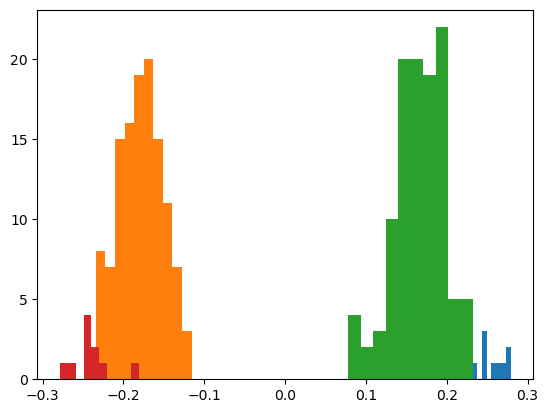

In [216]:
plt.hist(corr1)
plt.hist(corr2.flatten())
plt.hist(corr3.flatten())
plt.hist(corr4)

In [49]:
### New Filter_Configs with symmety checking...

def filter_configurations_with_symm(configurations, substrate):

    d = dict()
    for config in configurations:
        actv, checks = check_site_identity_volatilization(config, substrate)
        eqv_atoms_grouped = deepcopy(substrate.info['equivalent_atoms_grouped'])

        if checks:
            # Config has not been destroyed/volitalized
            if len(actv) == 2:
                # Remove symmetry duplicate configs
                a0, a1 = actv[0], actv[1]
                a0_equivalents = [symgroup for symgroup in eqv_atoms_grouped if a0 in symgroup][0]
                a1_equivalents = [symgroup for symgroup in eqv_atoms_grouped if a1 in symgroup][0]
                equivalent_active_sites = [sorted(sites) for sites in itertools.product(a0_equivalents, a1_equivalents)]
                equivalent_active_sites.remove(actv) #important

                sites_in_dict = [equivalent for equivalent in equivalent_active_sites if repr(equivalent) in d]

                if not len(sites_in_dict):
                    # No symmetry equivalent active sites present in dict...
                    # Remove duplicate configs, keeping lowest energy one
                    if repr(actv) not in d:
                        d[repr(actv)] = config
                    elif d[repr(actv)].info['energy'] < config.info['energy']:
                        d[repr(actv)] = config
                else:
                    # Equivalent sites present... do not add config
                    pass

            elif len(actv) == 1:
                a = actv[0]
                equivalent_active_sites = [symgroup for symgroup in eqv_atoms_grouped if a in symgroup][0]
                sites_in_dict = [equivalent for equivalent in equivalent_active_sites if equivalent in d]

                if not len(sites_in_dict):
                    #print('symmetry passed')
                    if a not in d:
                        d[a] = config
                    elif d[a].info['energy'] < config.info['energy']:
                        #print('energy updated', a, d[a].info['energy'], config.info['energy'])
                        d[a] = config
                else:
                    pass
                ## if len(actv) == 0:
                    # Volatialized... but on initial relaxation, adsorbate could briefly volatalize before coming back?
    return d

In [ ]:
def attach_active_site(configurations):
    for config in configurations:
        config.info['active_site'] = check_site_identity_volatilization(config, sub)[0][0]

In [ ]:
d0 = filter_configs_with_symm(oh_crude, sub)
d1 = filter_configs_with_symm(o_crude, sub)
d2 = filter_configs_with_symm(ooh_crude, sub)

oh_crude_filtered = deepcopy(list(d0.values()))
o_crude_filtered = deepcopy(list(d1.values()))
ooh_crude_filtered = deepcopy(list(d2.values()))

In [ ]:
attach_active_site(oh_crude_filtered)

In [ ]:
activesites_crude = [[i, j, k] for i, j, k in itertools.product(list(d0.keys()), list(d1.keys()), list(d2.keys()))]
activesites_crude = np.array(activesites_crude).reshape(len(list(d0.keys())), len(list(d1.keys())), len(list(d2.keys())), 3)

In [ ]:
print(len(oh_crude_filtered), len(o_crude_filtered), len(ooh_crude_filtered))

In [ ]:
# configsOOH = []
# for site in range(sub.info['nonH_count']):
#     configsOOH += build_configuration_from_site(OOH, substrate, site, f=h)

# configsOOH_relaxed = multi_run(configsOOH, runtype=f'opt vtight', calc_kwargs=calc_params, multi_process=multi_process)
# configsOOH_filtered = filter_configurations(configsOOH_relaxed, substrate)

In [152]:
eoh_crude = np.array([c.info['energy'] for c in oh_crude])
eoh_crude = np.delete(eoh_crude, 2)
eo_crude = np.array([c.info['energy'] for c in o_crude])
eooh_crude = np.array([c.info['energy'] for c in ooh_crude])

# eoh_full = np.array([c.info['energy'] for c in oh_full])
# eo_full = np.array([c.info['energy'] for c in o_full])
# eooh_full = np.array([c.info['energy'] for c in ooh_full])

eoh_ref = np.array([c.info['energy'] for c in oh_ref])
eo_ref = np.array([c.info['energy'] for c in o_ref])
eooh_ref = np.array([c.info['energy'] for c in ooh_ref])

In [ ]:
def get_same_keyed(keys_list, configurations):
    d = dict()
    for config in configurations:
        a = config.info['active_site']
        print(a)
        if a in keys_list:
            d[a] = config
    return d

In [295]:
### 3. Check for bad configs
gs = es
goh = eoh_crude
go = eo_crude
gooh = eooh_crude

Gcrude = free_energy_multidim(gs, goh, go, gooh)
overpotcrude = Gcrude.max(axis=3) - 1.23
rdscrude = Gcrude.argmax(axis=3)

In [296]:
[np.count_nonzero(rdscrude == i) for i in range(4)]

[83, 21, 1020, 86]

In [297]:
arg = np.unravel_index(overpotcrude.argsort(axis=None, kind='stable'), overpotcrude.shape)
indxs = np.dstack(arg)[0]

In [298]:
for l in indxs:
    print(l, '|', overpotcrude[*l], '|', rdscrude[*l])

[3 6 0] | 0.03435353501372562 | 2
[2 6 0] | 0.039521725532769114 | 0
[5 6 0] | 0.05904457919864514 | 0
[2 6 8] | 0.08343856114497727 | 2
[3 6 8] | 0.08343856114497727 | 2
[5 6 8] | 0.08343856114497727 | 2
[9 6 0] | 0.08970877634524443 | 1
[9 6 8] | 0.08970877634524443 | 1
[0 6 0] | 0.159477104067403 | 1
[0 6 8] | 0.159477104067403 | 1
[0 6 3] | 0.18474038515914915 | 2
[2 6 3] | 0.18474038515914915 | 2
[3 6 3] | 0.18474038515914915 | 2
[5 6 3] | 0.18474038515914915 | 2
[9 6 3] | 0.18474038515914915 | 2
[0 4 0] | 0.21243386897008465 | 2
[2 4 0] | 0.21243386897008465 | 2
[3 4 0] | 0.21243386897008465 | 2
[5 4 0] | 0.21243386897008465 | 2
[9 4 0] | 0.21243386897008465 | 2
[0 6 4] | 0.22826007943631454 | 2
[2 6 4] | 0.22826007943631454 | 2
[3 6 4] | 0.22826007943631454 | 2
[5 6 4] | 0.22826007943631454 | 2
[9 6 4] | 0.22826007943631454 | 2
[0 4 8] | 0.2615188951013363 | 2
[2 4 8] | 0.2615188951013363 | 2
[3 4 8] | 0.2615188951013363 | 2
[5 4 8] | 0.2615188951013363 | 2
[9 4 8] | 0.261518895

In [299]:
gs = es + zpes - ss
goh = eoh_ref + zpeoh_ref - soh_ref
go = eo_ref + zpeo_ref - so_ref
gooh = eooh_ref + zpeooh_ref - sooh_ref

G = free_energy_multidim(gs, goh, go, gooh)
overpot = G.max(axis=3) - 1.23
rds = G.argmax(axis=3)

In [300]:
arg_0 = np.unravel_index(overpot.argsort(axis=None, kind='stable'), overpot.shape)
indxs_0 = np.dstack(arg_0)[0]

In [301]:
for l in indxs_0:
    print(l, '|', overpot[*l], '|', rds[*l])

[0 6 0] | 0.21943892823815192 | 2
[2 6 0] | 0.21943892823815192 | 2
[3 6 0] | 0.21943892823815192 | 2
[9 6 0] | 0.21943892823815192 | 2
[0 6 3] | 0.2779000383293817 | 2
[2 6 3] | 0.2779000383293817 | 2
[3 6 3] | 0.2779000383293817 | 2
[9 6 3] | 0.2779000383293817 | 2
[5 6 0] | 0.29873507368306607 | 0
[5 6 3] | 0.29873507368306607 | 0
[0 6 4] | 0.31187258992763534 | 2
[2 6 4] | 0.31187258992763534 | 2
[3 6 4] | 0.31187258992763534 | 2
[5 6 4] | 0.31187258992763534 | 2
[9 6 4] | 0.31187258992763534 | 2
[0 6 8] | 0.31877056022817785 | 2
[2 6 8] | 0.31877056022817785 | 2
[3 6 8] | 0.31877056022817785 | 2
[5 6 8] | 0.31877056022817785 | 2
[9 6 8] | 0.31877056022817785 | 2
[0 4 2] | 0.3435597245399902 | 3
[0 6 2] | 0.3435597245399902 | 3
[2 4 2] | 0.3435597245399902 | 3
[2 6 2] | 0.3435597245399902 | 3
[3 4 2] | 0.3435597245399902 | 3
[3 6 2] | 0.3435597245399902 | 3
[5 4 2] | 0.3435597245399902 | 3
[5 6 2] | 0.3435597245399902 | 3
[9 4 2] | 0.3435597245399902 | 3
[9 6 2] | 0.343559724539990

In [302]:
# del gs, goh, go, gooh
zpe_s_loop(es, eoh_crude, eo_crude, eooh_crude)

0 (3, 6, 0) 0.03435353501372562
1 (0, 6, 0) 0.22546220388249028
2 (0, 6, 0) 0.22546220388249028
3 (0, 6, 0) 0.22546220388249028
4 (0, 6, 0) 0.22546220388249028
5 (0, 6, 0) 0.22546220388249028


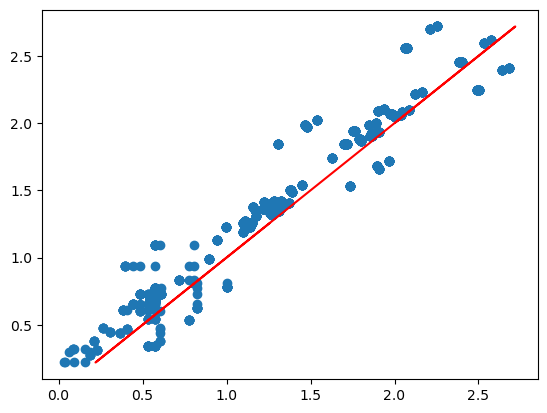

In [303]:
plt.scatter(overpotcrude.flatten(), overpot.flatten())
plt.plot(overpot.flatten(), overpot.flatten(), 'r')

----

In [ ]:
oh_ref = multi_run(configsOH, runtype='opt vtight', keep_folders=False, calc_kwargs={}, multi_process=6)

In [ ]:
oh_ref_tight = multi_run(configsOH, runtype='opt tight', keep_folders=False, calc_kwargs={}, multi_process=6)

In [ ]:
oh_ref_normal = multi_run(configsOH, runtype='opt normal', keep_folders=False, calc_kwargs={}, multi_process=6)

In [ ]:
oh_ref_lax = multi_run(configsOH, runtype='opt lax', keep_folders=False, calc_kwargs={}, multi_process=6)

In [ ]:
oh_ref_loose = multi_run(configsOH, runtype='opt loose', keep_folders=False, calc_kwargs={}, multi_process=6)

In [ ]:
oh_ref_crude = multi_run(configsOH, runtype='opt crude', keep_folders=False, calc_kwargs={}, multi_process=6)

In [ ]:
evtight = np.array([c.info['energy'] for c in oh_ref])
etight = np.array([c.info['energy'] for c in oh_ref_tight])
evnormal = np.array([c.info['energy'] for c in oh_ref_normal])
elax = np.array([c.info['energy'] for c in oh_ref_lax])
eloose = np.array([c.info['energy'] for c in oh_ref_loose])
ecrude = np.array([c.info['energy'] for c in oh_ref_crude])

In [ ]:
np.sort(evtight-ecrude)

In [ ]:
np.argsort(evtight-ecrude)

In [ ]:
oh = deepcopy(oh_ref_loose)

In [ ]:
# d = {k : None for k in range(sub.info['nonH_count'])}
d = dict()

for config in oh:
    actv, checks = check_site_identity_volatilization(config, sub)
    if checks:
        for a in actv:
            if a not in d:
                d[a] = config
                
            elif config.info['energy'] < d[a].info['energy']:
                print('Replaced @', a)
                d[a] = config
    else:
        print('failed')

In [ ]:
es = np.array([c.info['energy'] for c in list(d.values())])

In [ ]:
start = time.perf_counter()

new_configsOH = []
for config in d.values():
    confs = generate_opt_confs(config, numConfs=5, numThreads=4)
    min_energy_conf = confs.pop(0)
    new_configsOH.append(min_energy_conf)
    
print(time.perf_counter() - start)

In [ ]:
new_oh_ref = multi_run(new_configsOH, runtype='opt loose', keep_folders=False, calc_kwargs={}, multi_process=6)

In [ ]:
new_oh = deepcopy(new_oh_ref)

In [ ]:
for config in new_oh:
    actv, checks = check_site_identity_volatilization(config, sub)
    if checks:
        for a in actv:
            if a not in d:
                print('Found a new active site')
                d[a] = config
                
            elif config.info['energy'] < d[a].info['energy']:
                print('replaced an existing active site')
                d[a] = config

In [ ]:
e_updated = np.array([c.info['energy'] for c in list(d.values())])

In [ ]:
np.min(e_updated - es)

In [ ]:
ref = multi_run(list(d.values()), runtype='opt vtight', keep_folders=False, calc_kwargs={}, multi_process=6)

In [ ]:
eref = np.array([c.info['energy'] for c in ref])

---

#### Symmetry detection

In [ ]:
from rdkit.Chem.rdmolfiles import CanonicalRankAtoms

In [ ]:
def get_equiv_atoms_list(molecule):
    can_rank = list(CanonicalRankAtoms(molecule, breakTies=False))
    symmetries = {k : [] for k in can_rank}
    for j, r in enumerate(can_rank):
        symmetries[r].append(j)
        
    return list(symmetries.values())

def grouped_by_sym(metric, sym_groupings):
    metric_grouped = [[metric[i] for i in symgroup] for symgroup in sym_groupings]
    return metric_grouped

In [ ]:
eqal = get_equiv_atoms_list(Chem.RemoveHs(rdkit_smi))

In [ ]:
qd = [max(g) - min(g) for g in qs_grouped]

In [ ]:
qs_grouped

In [ ]:
for qs in qs_grouped:
    for q in qs_grouped:
        q

In [ ]:
[e[0] for e, q in zip(eqal, qd) if q < 0.0000001]

In [ ]:
eoh_grouped = grouped_by_sym(eoh, eqal)
eo_grouped = grouped_by_sym(eo, eqal)
eooh_grouped = grouped_by_sym(eooh, eqal)

zpeoh_grouped = grouped_by_sym(zpeoh, eqal)
zpeo_grouped = grouped_by_sym(zpeo, eqal)
zpeooh_grouped = grouped_by_sym(zpeooh, eqal)

soh_grouped = grouped_by_sym(soh, eqal)
so_grouped = grouped_by_sym(so, eqal)
sooh_grouped = grouped_by_sym(sooh, eqal)

In [ ]:
qs_grouped = grouped_by_sym(sub.info['qs'], eqal)
# fki_grouped = grouped_by_sym(fki, eqal)

In [ ]:
### Setting a charge difference threshold for identifying electronically distinct environments
### max(Qs) - min(Qs) > 0.001 Coloumb seems to work
[max(g) - min(g) for g in qs_grouped]

In [ ]:
[max(g) - min(g) for j, g in enumerate(eoh_grouped)]

In [ ]:
rdkit_smi

In [ ]:
# np.nanmean((zpeo - zpeo[:, None])[np.triu_indices(len(zpeo), k=1)])

In [ ]:
np.nanmax([max(g) - min(g) for g in eoh_grouped]), np.nanmax([max(g) - min(g) for g in eo_grouped]), np.nanmax([max(g) - min(g) for g in eooh_grouped])

In [ ]:
np.nanmax([max(g) - min(g) for g in zpeoh_grouped]), np.nanmax([max(g) - min(g) for g in zpeo_grouped]), np.nanmax([max(g) - min(g) for g in zpeooh_grouped])

In [ ]:
np.nanmax([max(g) - min(g) for g in soh_grouped]), np.nanmax([max(g) - min(g) for g in so_grouped]), np.nanmax([max(g) - min(g) for g in sooh_grouped])

#### Drawing

In [ ]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.drawOptions.baseFontSize = -1

from rdkit.Chem import Draw

In [ ]:
mol = Chem.MolFromSmiles(smi)
mol

In [ ]:
equivalent_atoms_list = get_equiv_atoms_list(mol)
len(equivalent_atoms_list), mol.GetNumAtoms()

In [ ]:
Draw.MolsToGridImage(len(equivalent_atoms_list)*[deepcopy(mol)],
                     legends=[f'{i}' for i in equivalent_atoms_list],
                     highlightAtomLists=equivalent_atoms_list,
                     subImgSize=(250,250))

In [ ]:
from rdkit.Chem.Lipinski import RotatableBondSmarts

In [ ]:
mol.GetSubstructMatches(RotatableBondSmarts)